# Example Implementation of an Incremental Classifier for Prediction on the Graz Dataset


The Graz Dataset frequency sampling rate is 250Hz/512Hz (depending on the version). The data is stored as a 2d array and can be better understaood by simply printing to console. In general, thee data contains details of trials against EEG recordings accross different channels(here, C3, Cz and C4).

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt 

import sys, os, os.path

import numpy as np
from utils import dataset, graz

import signal_processing.signal

import matplotlib.pyplot as plt 
from plotting.plot import plot_brain_signals

import utils.extract, utils.dwt, utils.features, utils.split
from reporting.report import normal_data_split_report, incremental_data_split_report, normalized_data_report

import classifier.base_classifier, classifier.svm
from classifier.incremental_classifier import IncrementalClassifier
from algorithm import learn_pp

from utils.models_utils import load_model, save_model

## Load Data

Data can be downloaded from: http://bnci-horizon-2020.eu/database/data-sets

All parameters are specific to the data being used. Additional documentation supporting data is provided with necessary and required values.

In [3]:
data_dir= "/home/eeshakumar/work/idp/code/bci-incremental-learning/data"
graz_data_dir= os.path.join(data_dir, "graz_data")
subject = 'A01'
trial_len = 8
cue_interval = [2, 6]
# Cue starts at 2s
cue_offset = 0
sampling_freq = 250

graz_data = graz.GrazA(graz_data_dir, subject, trial_len, cue_interval, cue_offset, sampling_freq)
graz_data.load()
graz_data.print_stats()
labels=graz_data.labels

EEG data shape : (483675, 5)
Labels shape : (240,)
Trials shape : (240,)
Trial Length : 8
Sampling frequency : 250
Cue Interval : [2, 6]
Number of classes : [0 1 2 3]


## Band-pass Filter

In [4]:
lowcut=10
highcut=70

btr_data = signal_processing.signal.butter_bandpass(graz_data, lo=lowcut, hi=highcut)

## Plot Brain Signals

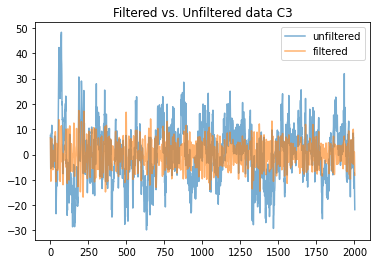

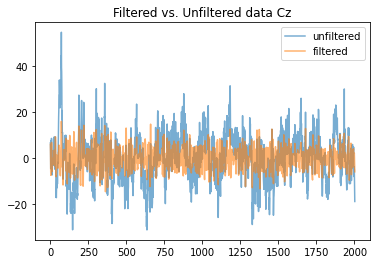

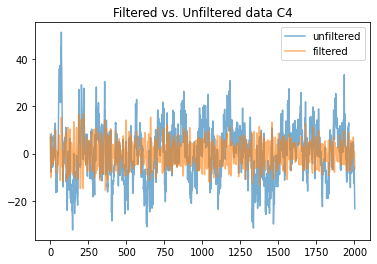

In [5]:
#By default the plot plots the first trial.
#0 C3, 1 Cz, 2 C4
plot_brain_signals(graz_data, btr_data, 0, title="Filtered vs. Unfiltered data C3")
plot_brain_signals(graz_data, btr_data, 1, title="Filtered vs. Unfiltered data Cz")
plot_brain_signals(graz_data, btr_data, 2, title="Filtered vs. Unfiltered data C4")

## Extract Trials

In [6]:
# Extract trials for 2class motor imagery data
data_class = utils.extract.extract_trials_4class(graz_data)
c1_idxs = np.where(labels==1)[0]
c0_idxs = np.where(labels==0)[0]
c2_idxs = np.where(labels==2)[0]
c3_idxs = np.where(labels==3)[0]

(60,) (60,) (60,) (60,)
(60, 2000)


## Spectrogram
NFFT=64 and nooverlap=50 also gives more bins but the plot appears more pixelated and not so easy to interpret. Vallues can be adjusted, keeping in mind that the nooverlatp value is always lesser than NFFT.

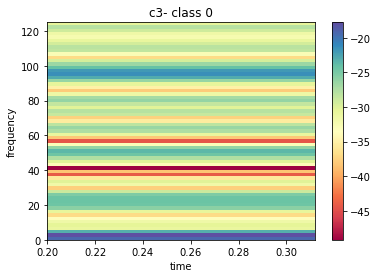

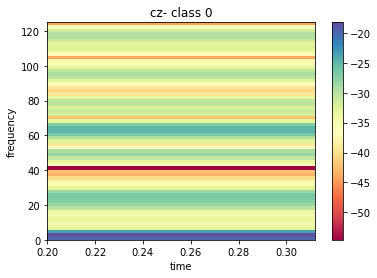

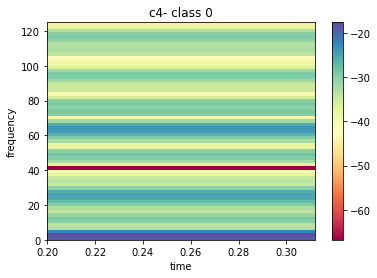

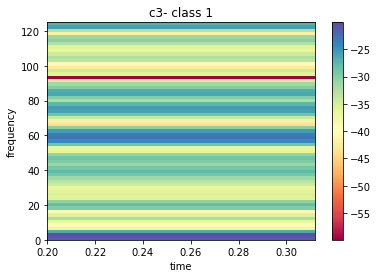

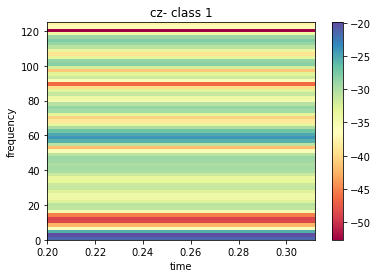

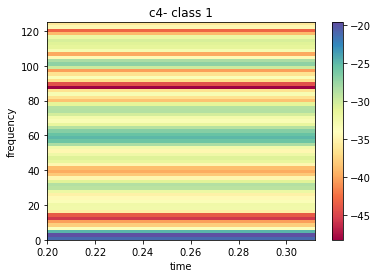

In [7]:
x=np.mean(data_class[0], axis=1)
FS=graz_data.sampling_freq

plt.specgram(x, NFFT=128, Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
plt.title('c3- class 0')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show()

x=np.mean(data_class[1], axis=1)
FS=graz_data.sampling_freq

plt.specgram(x , NFFT=128,   Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
plt.title('cz- class 0')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show()

x=np.mean(data_class[2], axis=1)
FS=graz_data.sampling_freq

plt.specgram(x , NFFT=128,   Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
plt.title('c4- class 0')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show()

x=np.mean(data_class[3], axis=1)
FS=graz_data.sampling_freq

plt.specgram(x , NFFT=128,   Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
plt.title('c3- class 1')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show()

x=np.mean(data_class[4], axis=1)
FS=graz_data.sampling_freq

plt.specgram(x , NFFT=128,   Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
plt.title('cz- class 1')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show()

x=np.mean(data_class[5], axis=1)
FS=graz_data.sampling_freq

plt.specgram(x , NFFT=128,   Fs=FS, noverlap=100, cmap=plt.get_cmap('Spectral'))
plt.title('c4- class 1')
plt.xlabel('time')
plt.ylabel('frequency')
plt.colorbar()
plt.show()

## Feature Extraction

### DWT Sampling
Discrete wavelet transform sampling allows approximation of features and is largely dependent on the sampling frequency.

In [8]:
w = [0, 250]

trials = graz_data.trials
features1= np.array(utils.dwt.dwt_features(btr_data, trials, 5, 250, w, 3, "db4"))
features2= np.array(utils.dwt.dwt_features(btr_data, trials, 5, 250, w, 4, "db4"))
features = np.concatenate((features1.T, features2.T)).T
features -= np.mean(features)
features = utils.features.normalize(features, 'min_max')

## Split Data

In [23]:
test_ratio = 0.2
split_features = np.array(utils.split.normal(features, labels.T, test_ratio=test_ratio, random_state=477))
x_train = split_features[0]
x_test = split_features[1]
y_train = split_features[2]
y_test = split_features[3]
normal_data_split_report(x_train, y_train, x_test, y_test)

Training data size: (192, 24)
Training labels size: (192,)
Test data size: (48, 24)
Test label size: (48,)


## Normalize Data

In [24]:
x_train = utils.features.normalize(x_train, 'mean_std')
x_train = utils.features.normalize(x_train, 'min_max')
normalized_data_report(x_train)

x_test = utils.features.normalize(x_test, 'mean_std')
x_test = utils.features.normalize(x_test, 'min_max')
normalized_data_report(x_test)

Normalized Data:
	Mean: 0.421
	Std dev: 0.104
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.413
	Std dev: 0.150
	Min: 0.000
	Max: 1.000



## Regular SVM Classifier

In [25]:
clf = classifier.svm.SVM('linear', 4, 4)
clf.train(x_train, y_train, x_test, y_test)

(<reporting.report.ClassificationReport at 0x7f51357fef60>,
 <classifier.svm.SVM at 0x7f5135806518>)

## Split Data

In [34]:
test_ratio = 0.4
split_ds = np.array(utils.split.normal(features, labels.T, test_ratio=test_ratio, random_state=477))
x_train = split_ds[0]
x_test = split_ds[1]
y_train = split_ds[2]
y_test = split_ds[3]
ds_features, ds_labels = utils.split.k_way_split(x_train, y_train)
incremental_data_split_report(ds_features, ds_labels, x_test, y_test)

Training data size: (72, 24)
Training labels size: (72,)
Test data size: (96, 24)
Test label size: (96,)

Training data size: (36, 24)
Training labels size: (36,)
Test data size: (96, 24)
Test label size: (96,)

Training data size: (36, 24)
Training labels size: (36,)
Test data size: (96, 24)
Test label size: (96,)



## Normalize Data

In [35]:
for k in range(len(ds_features)):
    ds_features[k] = utils.features.normalize(ds_features[k], 'mean_std')
    ds_features[k] = utils.features.normalize(ds_features[k], 'min_max')
    normalized_data_report(ds_features[k])
    
x_test = utils.features.normalize(x_test , 'mean_std')
x_test = utils.features.normalize(x_test , 'min_max')
normalized_data_report(x_test)

Normalized Data:
	Mean: 0.526
	Std dev: 0.138
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.328
	Std dev: 0.157
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.450
	Std dev: 0.155
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.327
	Std dev: 0.121
	Min: 0.000
	Max: 1.000



## Incremental SVM Classifier
This incremental classifier is a learning algorithm which trains on a base classifier, inour case SVM to improve accuracy. The caveat for such an algorithm is the existence of weak learners.

In [36]:
number_of_classifiers = 2
number_of_classes = 4
inc_clf = IncrementalClassifier(clf, number_of_classifiers, number_of_classes)

learn_pp.learn(inc_clf, 'rbf', ds_features, ds_labels, x_test, y_test, sample_ratio=1)

Data Subset 0:
	Classifier Iteration 0:
		epsilon: [0.09722222]
		beta: [0.10769231]
		Train Accuracy: [90.27777778]
		e_kt: [0.72222222]
		b_kt: [2.6]
		Test Accuracy: [25.]
		Error: [0.73958333]

Data Subset 0:
	Classifier Iteration 1:
		epsilon: [0.11346154]
		beta: [0.12798265]
		Train Accuracy: [90.27777778]
		e_kt: [0.11346154]
		b_kt: [0.12798265]
		Test Accuracy: [27.08333333]
		Error: [0.72916667]

Data Subset 1:
	Classifier Iteration 2:
		epsilon: [0.0625]
		beta: [0.06666667]
		Train Accuracy: [97.22222222]
		e_kt: [0.5]
		b_kt: [1.]
		Test Accuracy: [27.08333333]
		Error: [0.72916667]

Data Subset 1:
	Classifier Iteration 3:
		epsilon: [0.0625]
		beta: [0.06666667]
		Train Accuracy: [97.22222222]
		e_kt: [0.5]
		b_kt: [1.]
		Test Accuracy: [27.08333333]
		Error: [0.72916667]

Data Subset 2:
	Classifier Iteration 4:
		epsilon: [0.]
		beta: [0.]
		Train Accuracy: [100.]
		e_kt: [0.5]
		b_kt: [1.]
		Test Accuracy: [21.875]
		Error: [0.77083333]

Data Subset 2:
	Classifier Iter

## Plot error and accuracy
The plots intent to show the incremental changes in error as well as test accuracy depending on number of classifiers used. 

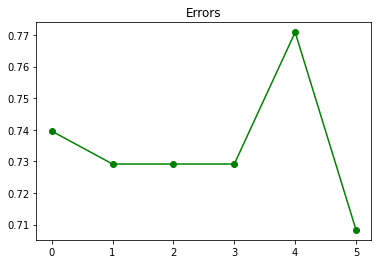

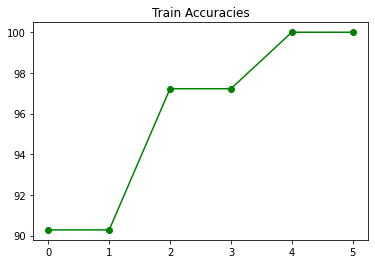

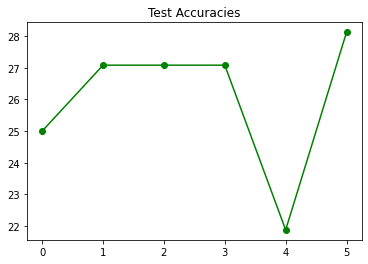

In [37]:
inc_clf.plot_errs()
inc_clf.plot_train_accuracy()
inc_clf.plot_test_accuracy()

## Save Model
Save the model (if needed). Here we save the incremental classifier used to predict in the previous runs.

In [ ]:
models_dir = "/path/to/models"
save_model(inc_clf, models_dir)

## Load Model
Load a saved model. This example loads a saved incremental classifier model.

In [ ]:
models_dir = "/path/to/models"
clf_name = ""
inc_clf = load_model(clf_name, models_dir)